In [26]:
print("all ok")

all ok


In [27]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [28]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
output = model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [40]:
@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

tools=[search]

llm_with_tool=model.bind_tools(tools)

tool_node=ToolNode(tools)

In [30]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content='I am doing great, thank you for asking! I am a large language model, and I am excited to help you with any questions or tasks you may have.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--d59cf361-4403-4780-a6b8-8fd679d6bc8b-0', usage_metadata={'input_tokens': 46, 'output_tokens': 230, 'total_tokens': 276, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 197}})]}

In [31]:
def router_function(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [32]:
memory = MemorySaver()

workflow = StateGraph(MessagesState)

workflow.add_node("llmwithtool", call_model)

workflow.add_node("mytools", tool_node)

workflow.add_edge(START, "llmwithtool")

workflow.add_conditional_edges("llmwithtool", router_function, {"tools":"mytools",END:END})

workflow.add_edge("mytools","llmwithtool")

In [33]:
app = workflow.compile(checkpointer=memory)

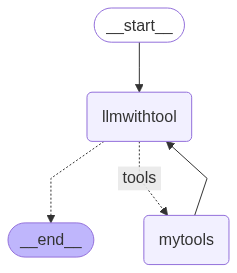

In [34]:
app

In [38]:
config={"configurable": {"thread_id": "1"}}
events=app.stream(
    {"messages":["what is a weather in delhi?"]},config=config,stream_mode="values"
    )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in delhi?
================================== Ai Message ==================================
Tool Calls:
  search (7efbebf4-7f69-4f67-8889-ff2d3b75fe8e)
 Call ID: 7efbebf4-7f69-4f67-8889-ff2d3b75fe8e
  Args:
    query: weather in delhi
================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny
================================== Ai Message ==================================

The weather in Delhi is 45 degrees and sunny.


In [42]:
events=app.stream(
    {"messages":["where the weather is 45 degrees?"]},config=config,stream_mode="values"
    )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

where the weather is 45 degrees?
================================== Ai Message ==================================

The weather is 45 degrees in Delhi.


In [43]:
config

{'configurable': {'thread_id': '1'}}

In [44]:
memory.get(config)

{'v': 4,
 'ts': '2025-08-22T17:19:15.504522+00:00',
 'id': '1f07f7c2-103a-6836-8019-10e474d42563',
 'channel_versions': {'__start__': '00000000000000000000000000000026.0.1809406977041318',
  'messages': '00000000000000000000000000000027.0.8620649371246513',
  'branch:to:llmwithtool': '00000000000000000000000000000027.0.8620649371246513',
  'branch:to:mytools': '00000000000000000000000000000017.0.814822740179523'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000025.0.8614349726656447'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000026.0.1809406977041318'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000016.0.11552774189056592'}},
 'updated_channels': ['messages'],
 'channel_values': {'messages': [HumanMessage(content='what is a weather in indore?', additional_kwargs={}, response_metadata={}, id='b20cd5b9-db01-4b23-9fed-14aaf547f6fb'),
   AIMessage(content='', additional_kwargs={'function_call':